# Simulation of NMR CPMG experiments with Ipywidgets

* [This noteboook is available at github.com/tlinnet/docker_relax](https://github.com/tlinnet/docker_relax/blob/master/JupyterLab/CPMG_NMR_relax_interactive.ipynb)

* [The widgets can be seen at nbviewer.jupyter.org by clicking here](http://nbviewer.jupyter.org/github/tlinnet/docker_relax/blob/master/JupyterLab/CPMG_NMR_relax_interactive.ipynb?)


# Interactive plotting

* [CR72 widget](#CR72_widget)
* ['NS CPMG 2-site expanded' widget](#NS_widget)
* [References and links](#references)

## Import code

In [1]:
### If relax is locally installed
import os, sys, pathlib
sys.path.append( os.path.join(str(pathlib.Path.home()), "software", "relax", "lib", "dispersion" ))
try:
    import cr72
    import ns_cpmg_2site_expanded
# Else download it
except ImportError:
    import urllib.request
    urllib.request.urlretrieve('https://raw.githubusercontent.com/nmr-relax/relax/master/lib/dispersion/cr72.py', 'cr72.py')
    urllib.request.urlretrieve('https://raw.githubusercontent.com/nmr-relax/relax/master/lib/dispersion/ns_cpmg_2site_expanded.py', 'ns_cpmg_2site_expanded.py')
    import cr72
    import ns_cpmg_2site_expanded

# 
print("Using file: %s"% cr72.__file__ )

Using file: /home/developer/work/JupyterLab/cr72.py


In [2]:
# Import python packages
import numpy as np
# Plotting
# Set backend.
# This must be done before importing.
#%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt

# Widgets
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

## CR72, 'NS CPMG 2-site expanded'

In [3]:
def model_calc(ax=None, model='CR72', cpmg_e=2500, isotope='15N', 
                relax_time = 0.06, 
                w0_1H_s1=750., w0_1H_s2=750., 
                R20_s1=13.9, R20_s2=13.9, 
                dw_s1=1.02, dw_s2=0.69,
                pA_s1=0.87, pA_s2=0.5, 
                kex_s1=4027., kex_s2=4061.):
    """
    @keyword ax:         The matplotlib axis to plot on.
    @keyword model:      The model to analyse. 'CR72' or 'NS'.
    @keyword cpmg_e:     The end value of the CPMG pulse train. In Hz.
    @keyword isotope:    The isotope of nuclei. Either 1H, 15N or 13C.
    @keyword relax_time: The experiment specific fixed time period for relaxation (in seconds).
    @keyword w0_1H:      The spin Larmor frequencies for proton. In MHz.
    @keyword R20:        The transversal relaxation rate. In rad/s.
    @keyword dw:         The chemical shift difference between states A and B (in ppm).
    @keyword pA:         The population of state A.
    @keyword kex:        The exchange rate. In rad/s
    """
    # Gyromagnetic Ratio in [MHz/T]
    # http://bio.groups.et.byu.net/LarmourFreqCal.phtml
    g = {'1H':42.576, '15N':4.3156, '13C':10.705}
    # Magnet Field Strength [T]
    B0_s1 = w0_1H_s1 / g['1H']
    B0_s2 = w0_1H_s2 / g['1H']
    # Larmor frequency for isotope [MHz]
    w0_isotope_s1 = g[isotope]*B0_s1
    w0_isotope_s2 = g[isotope]*B0_s2
    # Convert dw in ppm to rad/s
    dw_rad_s1 = dw_s1 * w0_isotope_s1*2*np.pi
    dw_rad_s2 = dw_s2 * w0_isotope_s2*2*np.pi

    # Make x values. In Hz.
    x_cpmg_frqs = np.linspace(40, cpmg_e, num=100)

    if model=='CR72':
        y_R2_s1 = cr72_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs)
        y_R2_s2 = cr72_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs)
    elif model=='NS':
        y_R2_s1 = ns_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time)
        y_R2_s2 = ns_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time)

    # Make labels
    label_s1 = "sfrq=%.1f MHz\nR20=%.1f rad/s\ndw=%.1f ppm\npA=%.3f \nkex=%.1f rad/s"%(w0_1H_s1, R20_s1, dw_s1, pA_s1, kex_s1)
    label_s2 = "sfrq=%.1f MHz\nR20=%.1f rad/s\ndw=%.1f ppm\npA=%.3f \nkex=%.1f rad/s"%(w0_1H_s2, R20_s2, dw_s2, pA_s2, kex_s2)
    label_s1_n = "sfrq=%.1f MHz R20=%.1f rad/s dw=%.1f ppm pA=%.3f kex=%.1f rad/s"%(w0_1H_s1, R20_s1, dw_s1, pA_s1, kex_s1)
    label_s2_n = "sfrq=%.1f MHz R20=%.1f rad/s dw=%.1f ppm pA=%.3f kex=%.1f rad/s"%(w0_1H_s2, R20_s2, dw_s2, pA_s2, kex_s2)
    
    # Plot
    # Update if already existing
    if ax.lines:
        # Update y-data. x-data is the same.
        ax.lines[0].set_ydata(y_R2_s1)
        ax.lines[1].set_ydata(y_R2_s2)

        # Update legend
        ax.legend((ax.lines[0], ax.lines[1]), (label_s1, label_s2), loc='center left', bbox_to_anchor=(1, 0.5))
        
        # Set axis limits
        p_ylim_up = np.max(np.concatenate((y_R2_s1, y_R2_s2)))
        # Round up to nearest 5
        p_ylim_up = p_ylim_up + (- p_ylim_up % 5 )
        ax.set_ylim(0, p_ylim_up)
    # Create new plot, if not existing
    else:
        # Plot
        plt.plot(x_cpmg_frqs, y_R2_s1, label=label_s1)
        plt.plot(x_cpmg_frqs, y_R2_s2, label=label_s2)
        # Set labels
        ax.set_xlabel = "CPMG pulse train frequency v [Hz]"
        ax.set_ylabel = "R2,eff rad/s"

        # Set axis limits
        p_ylim_up = ax.get_ylim()[-1]
        # Round up to nearest 5
        p_ylim_up = p_ylim_up + (- p_ylim_up % 5 )
        ax.set_ylim(0, p_ylim_up)
        # x_lim does not change
        ax.set_xlim(0, cpmg_e)

        # Put legend outside
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # Update canvas
    fig.canvas.draw()

# Setup parameters
def cr72_calc(R20=None, dw_rad=None, pA=None, kex=None, cpmg_frqs=None):
    # For simpel model, R20A and R20B is the same
    R20A = R20B = R20
    
    # Make empty y_val
    y_R2 = np.zeros(cpmg_frqs.size)
    # Calculate y, and make in-memore replacement in y
    cr72.r2eff_CR72(r20a=R20A, r20a_orig=R20A, r20b=R20B, r20b_orig=R20B, 
           pA=pA, dw=dw_rad, dw_orig=dw_rad, kex=kex, 
           cpmg_frqs=cpmg_frqs, back_calc=y_R2)
    return y_R2

# Setup parameters
def ns_calc(R20=None, dw_rad=None, pA=None, kex=None, cpmg_frqs=None, relax_time=None):
    # Calculate properties
    inv_relax_time = 1.0 / relax_time
    # Collect power
    power_arr = []
    tau_cpmg_arr = []
    for cpmg_frq in cpmg_frqs:
        # num_cpmg
        power = int(round(cpmg_frq * relax_time))
        power_arr.append(power)
        # tcp
        tau_cpmg = 0.25 * relax_time / power
        tau_cpmg_arr.append(tau_cpmg)
    # Conver to numpy
    num_cpmg = np.asarray(power_arr)
    tcp = np.asarray(tau_cpmg_arr)

    # Make empty y_val
    y_R2 = np.zeros(cpmg_frqs.size)    
    
    # Calculate y, and make in-memore replacement in y
    ns_cpmg_2site_expanded.r2eff_ns_cpmg_2site_expanded(
            r20=R20, pA=pA, dw=dw_rad, dw_orig=dw_rad, kex=kex, 
            relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, 
            back_calc=y_R2, num_cpmg=num_cpmg)
    return y_R2

## CR72 widget <a name="CR72_widget"></a>

<IPython.core.display.Javascript object>


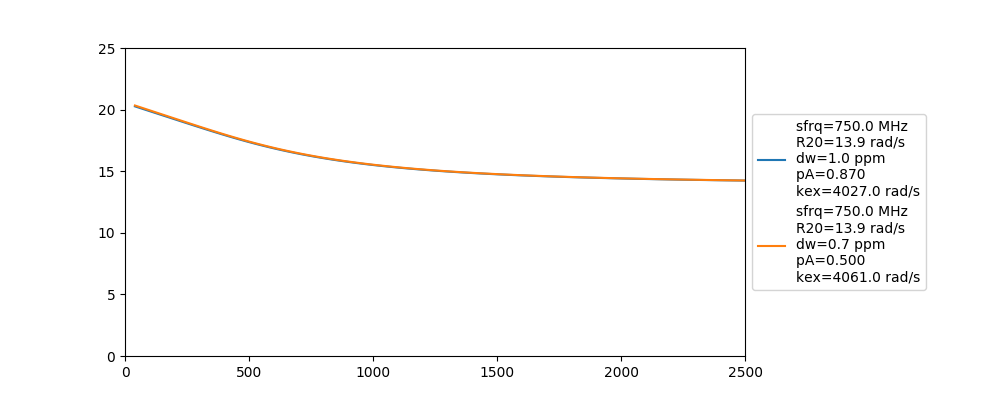

In [4]:
# Make figure
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_cr72 = interactive(model_calc, ax=fixed(ax),
                       model=fixed('CR72'), cpmg_e=fixed(2500), isotope=fixed('15N'), relax_time =fixed(0.06), 
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.))
# Update fig
widget_cr72

## 'NS CPMG 2-site expanded' widget <a name="NS_widget"></a>

<IPython.core.display.Javascript object>


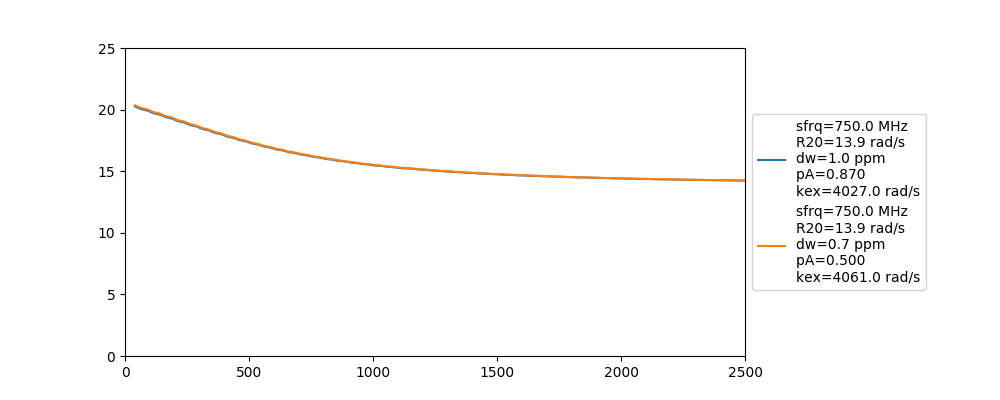

In [5]:
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_ns = interactive(model_calc, ax=fixed(ax),
                       model=fixed('NS'), cpmg_e=fixed(2500), isotope=fixed('15N'), relax_time =fixed(0.06), 
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.))
fig.canvas.draw()
widget_ns

# References <a name="references"></a>

## Ipywidgets documentation

* [Using Interact](http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)
* [Widget List](http://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html)
* [How to 'Save Notebook Widget State' before exporting to online view.](http://ipywidgets.readthedocs.io/en/stable/embedding.html)
* [Matplotlib documentation on backend.]( https://matplotlib.org/faq/usage_faq.html#what-is-a-backend)
* [stackoverflow on updates a plot in a loop](https://stackoverflow.com/questions/34486642/what-is-the-currently-correct-way-to-dynamically-update-plots-in-jupyter-ipython)
* [Widget at plotting in matplotlib. Does not work as intended.](http://nbviewer.jupyter.org/github/jenshnielsen/netcdf-lesson/blob/master/Interactive%20plotting%20with%20nbagg.ipynb)


## Code reference in relax

* [The target function to prepare data](https://github.com/nmr-relax/relax/blob/master/target_functions/relax_disp.py)
* [The library function of CR72](https://github.com/nmr-relax/relax/blob/master/lib/dispersion/cr72.py)
* [The library function of 'NS CPMG 2-site expanded'](https://github.com/nmr-relax/relax/blob/master/lib/dispersion/ns_cpmg_2site_expanded.py)